<a href="https://colab.research.google.com/github/shcho11/00.Projects_KoreaUniv_2022-2/blob/main/202212_NaverNewsCrawling_and_WordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 워드클라우드(WorldCloud) 실습 
- 네이버뉴스댓글 크롤링하여 댓글 내용에서 명사 키워드 추출, 이를 이용한 워드클라우드 만들기
- 2022.12

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 7.8 MB/s 
     |████████████████████████████████| 384 kB 56.3 MB/s 
     |████████████████████████████████| 140 kB 60.6 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd

# colab 에서 chrome driver 사용하기. 
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:13 h

In [32]:
# 네이버 뉴스 댓글정보 수집 함수 1 (작성자, 작성시간, 댓글내용)

def get_naver_news_all(url, wait_time=5, delay_time=1.0):

  #Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')        # Head-less 설정
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver', options=options)
    
  driver.implicitly_wait(wait_time)
  driver.get(url)

  while True:
    try:
            more = driver.find_elements(By.CSS_SELECTOR,'a.u_cbox_btn_more')
            more.click()
            time.sleep(delay_time)
    except:
            break

  html = driver.page_source
  # print(html)
    
  # soup = BeautifulSoup(html, 'lxml') #html.parser
    
  # 1)작성자
  # selenium으로 작성자 포함된 태그 모두 수집
  nicknames = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_nick')
    
  # 리스트에 텍스트만 담기 (리스트 컴프리핸션 문법)
  list_nicknames = [nick.text for nick in nicknames]

  # 2)댓글 시간
  datetimes = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_date')
  list_datetimes = [datetime.text for datetime in datetimes]

  # 3)댓글 내용
  contents = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_contents')
  list_contents = [content.text for content in contents]
    
  # 4)작성자, 댓글 시간, 내용을 셋트로 취합
  list_sum = list(zip(list_nicknames,list_datetimes,list_contents))
    
  # 드라이버 종료
  driver.quit()
    
  # 함수를 종료하며 list_sum을 결과물로 제출
  # return list_sum
  return list_sum

In [41]:
# 네이버 뉴스 댓글정보 수집 함수 2 (댓글내용만) 

def get_naver_news_comments(url, wait_time=5, delay_time=1.0):

  #Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')        # Head-less 설정
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver', options=options)
    
  driver.implicitly_wait(wait_time)

  driver.get(url)

  while True:
    try:
      more = driver.find_element(By.CSS_SELECTOR,'a.u_cbox_btn_more')
      more.click()
      time.sleep(delay_time)
    except:
      break

  html = driver.page_source
  # print(html)
    
  # soup = BeautifulSoup(html, 'lxml') #html.parser
    
  # 댓글 내용
  # selenium으로 댓글내용 포함된 태그 모두 수집
  contents = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_contents')
  #contents = soup.select('span.u_cbox_contents')
    
  # 리스트에 텍스트만 담기 (리스트 컴프리핸션 문법)
  list_contents = [content.text for content in contents]

  # 드라이버 종료
  driver.quit()
    
  # 함수를 종료하며 list_sum을 결과물로 제출
  # return list_sum
  return list_contents

### 댓글 크롤링 대상 기사 : <YTN> 집값 끝없는 추락...송도 등 반토막 아파트 속출
- 입력2022.12.03. 오전 7:28  수정2022.12.03. 오전 7:33
- https://n.news.naver.com/article/052/0001821320

In [42]:
# 실제 함수 실행 및 엑셀로 저장
if __name__ == '__main__': # 설명하자면 매우 길어져서 그냥 이렇게 사용하는 것을 권장
    
    # 원하는 기사 url 입력
    url = "https://n.news.naver.com/article/comment/052/0001821320"
    
    # 함수 실행
    comments = get_naver_news_comments(url)
    
    # 엑셀의 첫줄에 들어갈 컬럼명
    # col = ['작성자','시간','내용']
    
    # pandas 데이터 프레임 형태로 가공
    # df = pd.DataFrame(comments, columns=col)
    df = pd.DataFrame(comments)

    # 데이터 프레임을 엑셀로 저장 (파일명은 'news.xlsx', 시트명은 '뉴스')
    # df.to_excel('news.xlsx', sheet_name='뉴스')
    df.to_csv('news1.csv')

In [43]:
import os 
os.getcwd()

'/content'

In [44]:
# pd.read_excel('news.xlsx', sheet_name = '뉴스')
news2 = pd.read_csv('news1.csv')
news2 = news2.drop(news2.columns[0], axis=1)
news2

,0
0,집값이 정상화 되고있는건데 뭐가 문제죠?
1,"3~4억 짜리가 12억씩 했으니 아직 멀었다, 부동산 투기자들 패가망신 시켜야합니다"
2,초 고령 사회 진입하고 집 살 사람이 없음. 문재인정부에서 집사지 말라고 그렇게 말...
3,반토막 좋아하네 거기서 반에 반은 더내려야 정상이지
4,"그거 4억짜리인데, 12억으로 1년만에 올려서 초고가 만들고, 이제 6억대로 70%..."
...,...
493,"이부망천은 진리이자, 팩트며, 과학이다"
494,영끌 2찍들 죽어나겠다. ㅜㅠ 본인 손가락을 탓하시오!!
495,문재인이 결국 옳았고 재평가가 시급함. 그는 잘못 없다. 너거가 말을 안 들은 탓임.
496,집없는세입자들이 집주인 망해라 폭락기우제 지내고있으니 참.. 벼락거지들 인성 어디가...


In [45]:
news2.to_csv('news2.csv')

In [46]:
!pip install konlpy 
from konlpy.tag import Okt 
from wordcloud import WordCloud 
from PIL import Image 
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 6.0 MB/s 
     |████████████████████████████████| 465 kB 55.0 MB/s 


In [47]:
# 코랩 한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,297 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [49]:
file = open('news2.csv')
reply_text = file.readlines()
file.close()
print(reply_text)

# file = open('drive/MyDrive/20221111_chosunilbo_opinion.txt')

[',0\n', '0,집값이 정상화 되고있는건데 뭐가 문제죠?\n', '1,"3~4억 짜리가 12억씩 했으니 아직 멀었다, 부동산 투기자들 패가망신 시켜야합니다"\n', '2,초 고령 사회 진입하고 집 살 사람이 없음. 문재인정부에서 집사지 말라고 그렇게 말했는데 투기세력들이 조장해서 집값 올린거. 더 떨어져야 함!\n', '3,반토막 좋아하네 거기서 반에 반은 더내려야 정상이지\n', '4,"그거 4억짜리인데, 12억으로 1년만에 올려서 초고가 만들고, 이제 6억대로 70% 올려서 팔면서, 반토막 이라고 호구 모집하는중이다~!! 그냥 투기꾼들이 작전주 만드는것이다~!!"\n', '5,어정쩡한 위치 아파트들이 조정 받는거고 진짜 알짜는 신고가 찍고 있는데 양극화가 더 심해질 것 같은데\n', '6,송도는 25평 3억대가 맞음.. 더 내려가야 됨.\n', '7,"송도 , 동탄 ,광교 는 3억 ㅡ 검단 ,청라,계양 2억 , 김포 3억 ㅡ 남양주 다산 3억 , 양주 ,의정부 2억 미만입니다...하남 4억 , 강동 고덕 6억 , 둔촌 8억 미만 , 위레 5억 , 용인 3억 ,수지 4억 미만입니다...수원 2억, 화성 미분양 빈집 널려있다 . 일산 , 고양 2억 ..삼송 3억(기준은 국평 33 신축 기준)"\n', '8,6억에산 집이 일년만에 12억 될때 기사한줄 없더라 쯧\n', '9,엄살 부리지 마세요. 아직도 집값이 끄떡 없는곳이 많습니다. 더 많이 더 어래동안 떨어져야해요. 기자님\n', '10,아파트 소유자 분들에게는 미안한 얘기지만 조그마한 콘크리트 공간이 정말 터무니 없이 올랐었다. 이제 대지비와 건축비 그리고 적정이윤을 포함한 가격 정도로 더 내려가야 한다. 평생벌어 집 값에 지불하면 되겠나?\n', '11,오른건 생각안하고 내리면 난리다...월급받아서 살수있어야 집이지..평생벌어도 못살가격이 이나라 아파트 가격이다..집값좀내리게 그냥두자\n', '12,"허위기사, 반토막 아파트가 속출이 아니라 정상가격으로 복귀하는 아파트가 속출이 맞는 표현이지!"\n'

In [57]:
okt = Okt()
text1 = ''
for sentence in reply_text : 
  for noun in okt.nouns(sentence) : 
    if noun in ['데','이','그','것','건','전','사','배','등','중','못','수','저','더'] : 
      pass
    else : 
     text1 += noun + ' '

print(text1)

집값 정상화 뭐 문제 리가 부동산 투 기자 패가망신 초 고령 사회 진입 집 살 사람 문재인 정부 집사 말 말 투기 세력 조장 집값 함 반토막 거기 반 반 정상 그거 초고 이제 팔면 반토막 호구 모집 중이 그냥 투기 전주 위치 아파트 조정 진짜 알짜 신고 양극화 송도 평 송도 동탄 광교 청라 계양 김포 남양주 다산 양주 의정부 미만 하남 강동 고덕 둔촌 미만 위레 용인 수지 미만 수원 화성 미분 빈집 일산 고양 삼송 기준 국평 신축 기준 집 년 때 줄 엄살 부리 집값 떡 곳 어 동안 기자 아파트 소유자 분 얘기 콘크리트 공간 정말 터 무니 이제 비 건축 비 적정 이윤 포함 가격 정도 평생 집 값 지불 생각 안 난리 월급 집 평생 가격 이나라 아파트 가격 집값좀 자 허위기사 반토막 아파트 속출 정상 가격 복귀 아파트 속출 표현 송 도 바 바람 습기 황사 그다지 주거 환경 부동산 폭락 옴 투기 논 가격 송도 적정 금액 서쪽 땅끝 마을 건물 잔뜩 사람 유령도시 원래 가격 집값 폭락 호들갑 서울 부동산 가격 투기 작전 세력 악덕 부동산 중개업 소 준비 부동산 가격 인플레이션 서민 전세 기간 및 전세 금액 상한 한도 법 규제 하니 강남 부동산 중개업 소 정부 조롱 듯 기존 전세 금액 찍찍 거기 걸 실 거주 아파트 가격 규제 부동산 중개업 소의 자격 모두 몰수 인터넷 직거래 대한민국 기성세대 반성 투기 꾼 하야 중국인 매수 매도 피해 송도 크게 대한민국 아파트 가격 좌지우지 중국인 중심 제주도 중국인 투자 유치 주택 가격 제주도 지사 장관 존재 외국인 중국인 투자 세력 폭 가격 등락 수십 걸 누가 투기 위 가격 거품 폭등 팍 가족 거래 언론 서민 입장 집값 정상 집값 때 정부 욕 너희 이중 행태 송도 그냥 뭐 외진 곳 평촌 의왕 인천 김포 분당 하남 개 거품 집값 공무원 봉급 기준 정도 알뜰 살 정도 미처 투기 꾼 젠 고개 때 자 반 가격 사이 집값 이상 말 집값 정상화 해 송도 주민 어깨 힘 좀 누가 강남 집 인생 뻥튀기 사람 때문 갈수록 집 기사 기자 놈 청약 광고 가

In [88]:
import io 

df_text1 = pd.read_csv(io.StringIO(text1), sep=",")
df_text1.to_csv('df_text1.csv')

In [79]:
from PIL import Image 
mask_image = np.array(Image.open('drive/MyDrive/house2.jpg'))

wc = WordCloud(background_color = 'white',
               font_path = 'drive/MyDrive/HMFMMUEX.TTC',
               max_words = 100,
               max_font_size = 100,
               min_font_size = 10,
               mask = mask_image,
               colormap = 'plasma_r').generate(text1) # colormap : https://www.kaggle.com/code/niteshhalai/wordcloud-colormap
wc.to_file('wc.png')

In [52]:
!ls -a

.  ..  .config	drive  news1.csv  news2.csv  sample_data  wc.png


### 마스크이미지가 white colored background를 갖는지 확인 (RGB 255,255,255)
- 만일, 마스크이미지의 np.array가 [255,255,255] 형태를 보이지 않는다면, 아래 링크에 설명된 코드로 transform 해줘야함.
- 그렇지 않으면, wordcloud결과가 mask image에 fit되지 않는 문제 발생할 수 있음.
- https://stackoverflow.com/questions/50435433/wordcloud-words-not-fitting-to-mask

In [59]:
print(mask_image)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


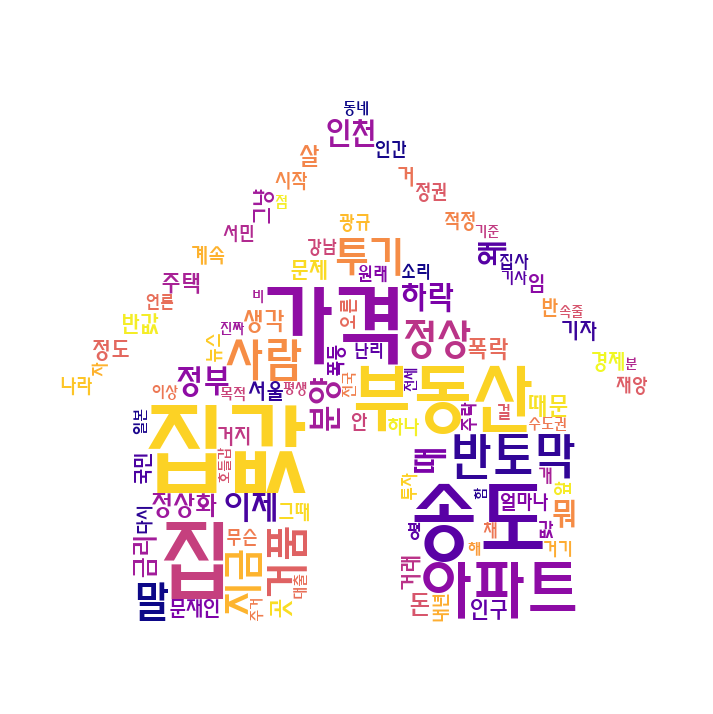

In [80]:
from IPython.display import Image
Image('wc.png')